In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

c:\Users\mayan\anaconda3\envs\otto_pyenv\lib\site-packages\pyarrow\compute.py:198: RuntimeWarning: Python binding for CumulativeSumOptions not exposed
  .format(class_name), RuntimeWarning)
c:\Users\mayan\anaconda3\envs\otto_pyenv\lib\site-packages\pyarrow\compute.py:198: RuntimeWarning: Python binding for RankOptions not exposed
  .format(class_name), RuntimeWarning)


In [2]:
train = pd.read_parquet('archive/train.parquet')
# test = pd.read_parquet('../input/otto-full-optimized-memory-footprint/test.parquet')

In [3]:
train.head()

,session,aid,ts,type
0,0,1517085,1659304800,0
1,0,1563459,1659304904,0
2,0,1309446,1659367439,0
3,0,16246,1659367719,0
4,0,1781822,1659367871,0


In [4]:
aid_vct = train['aid'].value_counts()

In [5]:
aid_vct

1460571    129004
485256     126836
108125     118524
29735      113279
1733943    105091
            ...  
353667          3
279299          3
1320306         3
1816720         3
651154          3
Name: aid, Length: 1855603, dtype: int64

### Transform Data

In [4]:
grouped_df = train.groupby('session')

In [5]:
grouped_df_size = grouped_df.size()
grouped_df_size

session
0           276
1            32
2            33
3           226
4            19
           ... 
12899774      2
12899775      2
12899776      2
12899777      2
12899778      2
Length: 12899779, dtype: int64

In [6]:
grouped_df_size.describe()

count    1.289978e+07
mean     1.679999e+01
std      3.357738e+01
min      2.000000e+00
25%      3.000000e+00
50%      6.000000e+00
75%      1.500000e+01
max      5.000000e+02
dtype: float64

In [7]:
grouped_df_size.value_counts()

2      2494185
3      1614198
4      1167007
5       872787
6       689743
        ...   
498          4
491          3
499          2
500          2
496          1
Length: 499, dtype: int64

In [8]:
grouped_df_size.value_counts().tail(20)

473    23
478    21
484    21
483    21
485    17
486    17
490    16
487    13
488    13
489    13
493    10
495     9
494     7
492     7
497     5
498     4
491     3
499     2
500     2
496     1
dtype: int64

<AxesSubplot:ylabel='Frequency'>

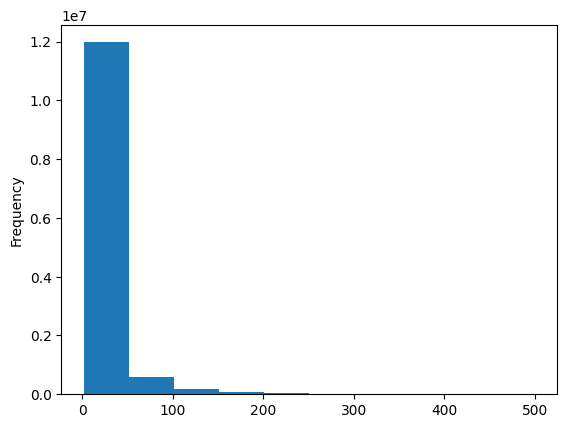

In [9]:
grouped_df_size.plot(kind='hist')

In [10]:
grouped_df_size

session
0           276
1            32
2            33
3           226
4            19
           ... 
12899774      2
12899775      2
12899776      2
12899777      2
12899778      2
Length: 12899779, dtype: int64

### Pyspark

In [7]:
import pyspark
from pyspark.sql import SparkSession

In [8]:
spark = SparkSession.builder.getOrCreate()

In [9]:
sparkDF = spark.read.parquet('archive/train.parquet')

In [31]:
from petastorm.spark import SparkDatasetConverter, make_spark_converter



c:\Users\mayan\anaconda3\envs\otto_pyenv\lib\site-packages\petastorm\spark\spark_dataset_converter.py:28: FutureWarning: pyarrow.LocalFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
  from pyarrow import LocalFileSystem


In [ ]:
spark.conf.set(SparkDatasetConverter.PARENT_CACHE_DIR_URL_CONF, 'file:///dbfs/...')

In [7]:
sparkDF.show()

+-------+-------+----------+----+
|session|    aid|        ts|type|
+-------+-------+----------+----+
|      0|1517085|1659304800|   0|
|      0|1563459|1659304904|   0|
|      0|1309446|1659367439|   0|
|      0|  16246|1659367719|   0|
|      0|1781822|1659367871|   0|
|      0|1152674|1659367885|   0|
|      0|1649869|1659369893|   1|
|      0| 461689|1659369898|   1|
|      0| 305831|1659370027|   2|
|      0| 461689|1659370027|   2|
|      0| 362233|1659370064|   0|
|      0|1649869|1659370067|   0|
|      0|1649869|1659371003|   0|
|      0| 984597|1659371033|   0|
|      0|1649869|1659371042|   0|
|      0| 803544|1659371044|   0|
|      0|1110941|1659371104|   0|
|      0|1190046|1659371123|   0|
|      0|1760685|1659375531|   0|
|      0| 631008|1659375544|   0|
+-------+-------+----------+----+
only showing top 20 rows



In [8]:
sparkDF.rdd.getNumPartitions()

20

In [22]:
grpd_spdf = sparkDF.groupBy('session', 'type')

In [1]:
from pyspark import SparkContext
SparkContext.setSystemProperty('spark.executor.memory', '5g')
sc = SparkContext("local", "App Name")


In [2]:
sc._conf.get('spark.executor.memory')

'5g'

In [17]:
sparkDF['session'].distinct().collect()

TypeError: 'Column' object is not callable

In [29]:
from pyspark.sql.functions import col
session_pydf = sparkDF.where(
  (col('session') ==15))


In [30]:
session_pydf.toPandas().sort_values('ts')

,session,aid,ts,type
0,15,1464271,1659304800,0
1,15,1464271,1659304821,1
2,15,1464271,1659348617,0
3,15,1763604,1659373313,0
4,15,632365,1659373405,0
...,...,...,...,...
81,15,973001,1661625213,0
82,15,11972,1661625225,0
83,15,567363,1661625294,0
84,15,1104350,1661625353,0


In [10]:
sparkDF.write.option("header",True) \
        .partitionBy("session") \
        .mode("overwrite") \
        .csv("spark_df")

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [ ]:
# create pytorch dataset
# create model
# write training loop 
# use for inference